# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.decompose_feedback import decompose_real_time_feedback


# Except subjects for predictors :
problematic_subjects_misc = ["611d60c383f4f70ff4bc99fd", # S2 : Did the task twice 
                             "66a74bdfdcaccdc0703894d5", # Consent revoked 
                            "667d92f2ea5c1542f417285d",
                            "6548f570022275786186ffbd"]
                
                

# problematic_subjects_fraudulent =["66bb5c09526e6d80f1146800"]
                # This subject had "eclectic performances" so say the least
                # Left fullscreen twice and missed 4 actions


# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "003"
# Study 2 : the std of the was 0.025,0.1 and 0.175
PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = []
for prolific_study_id in PROLIFIC_STUDY_IDs:
    task_results = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,prolific_study_id,
                                                              process_feedback_data_stream=True,override_save=False)
    print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
    TASK_RESULTS_ALL += task_results
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")


 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.


## 1. Dataframe building

In [2]:
# The initial datframe is the first tuple in our task result list of tuples : 
subjects_df = pd.DataFrame([entry[0] for entry in TASK_RESULTS])

# Avoid too many categories : 
subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

category_counts = subjects_df['Nationality'].value_counts()
threshold = 2
subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

# There was a single noise term for the whole training for each subject : 
subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in TASK_RESULTS]

# We add it to the df : 
subjects_df["feedback_noise_std"] = subject_noise_parameters

# # Create a pandas dataframe from the list of subject dictionnaries :

# In this dataframe, we're interested in sotring various kinds of data from the trials : 
# 1/ Data from the instruction phase

# 2/ Data from the feedback gauge :
# Timestep values :
all_subject_scores = [subjdata[2]["scoring"] for subjdata in TASK_RESULTS]
subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
# Real time gauge values :
subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in TASK_RESULTS] # Each element is a list of list os arrays (with varying shape)

# 3/ Data from the hidden grid :
# The grid for a specific trial: 
trial_grids = [entry[2]["process"]["grids"] for entry in TASK_RESULTS]
subjects_df["grid_layout"] = trial_grids
# Position value :
subject_positions = [entry[2]["process"]["positions"] for entry in TASK_RESULTS]
subjects_df["subject_positions"] = subject_positions

goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in TASK_RESULTS]
subjects_df["goal_position"] = goal_positions

def euclidian_distance(position,goal):
    return jnp.linalg.norm(position-goal,2)
gs = trial_grids[0][0].shape
maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


# 4/ Data from the realized actions :

# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"] # Constant across all subjects + conditions
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
# print(all_actions_data)
# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]


# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

Nactions = all_actions_data[...,0,0].size
Nmissed_actions = (~both_points_only).sum()
print("A total of {}/{} actions were missed. ({:.2f} %)".format(Nmissed_actions,Nactions,100*Nmissed_actions/Nactions))

subjects_df["raw_points"] = list(all_actions_data)


# Encoded barycenters :
barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
subjects_df["action_barycenters"] = list(barycenters)

# Encoded euclidian distance between points :
action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
subjects_df["action_distances"] = list(action_distances)

# Encoded evolution of point angles :
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
subjects_df["action_angles"] = list(angles)

# Encoded delays between stimuli, point1 and point2 :
all_action_delays = all_actions_data[...,-1,2]
unfit_actions = (all_action_delays<10)
subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()

# Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
last_k_trials,last_t_timesteps = 3,5
all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


# And for the blind trial :
blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()

A total of 33/15950 actions were missed. (0.21 %)


Let's discretize the observations as seen by the subjects :

(145, 11, 10)
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


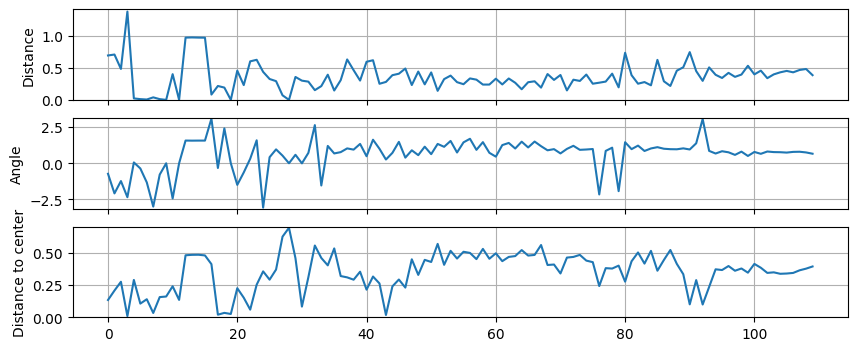

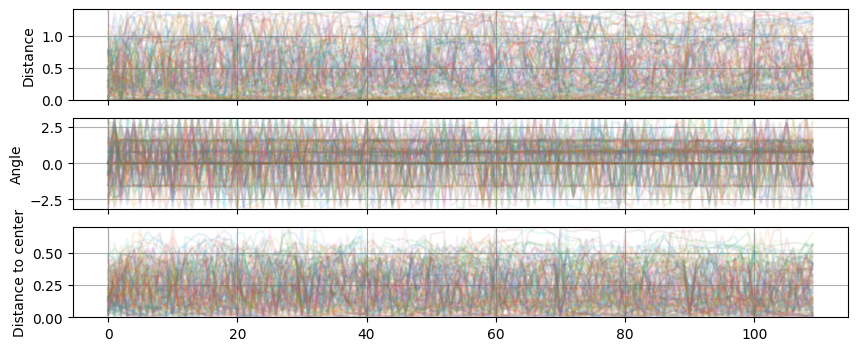

In [3]:

all_barycenters = np.stack(subjects_df["action_barycenters"],axis=0)
all_angles = np.stack(subjects_df["action_angles"],axis=0)
all_distances = np.stack(subjects_df["action_distances"],axis=0)

all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

print(all_dist_to_center.shape)

plot_these = {
    "distance":all_distances,
    "angle":all_angles,
    "position":all_dist_to_center,
}


one_subj_id = 95

fig,axs = plt.subplots(3,1,figsize=(10,4),sharex=True)
axs[0].set_ylim([0,np.sqrt(2)])
axs[0].set_ylabel("Distance")

axs[1].set_ylim([-np.pi,np.pi])
axs[1].set_ylabel("Angle")

axs[2].set_ylim([0,0.5*np.sqrt(2)])
axs[2].set_ylabel("Distance to center")

for k,(key,val) in enumerate(plot_these.items()):
    axs[k].plot(np.reshape(val[one_subj_id],-1),label=key)
    axs[k].grid()
    print(k)
    


fig,axs = plt.subplots(3,1,figsize=(10,4),sharex=True)
axs[0].set_ylim([0,np.sqrt(2)])
axs[0].set_ylabel("Distance")

axs[1].set_ylim([-np.pi,np.pi])
axs[1].set_ylabel("Angle")

axs[2].set_ylim([0,0.5*np.sqrt(2)])
axs[2].set_ylabel("Distance to center")
for subj in range(val.shape[0]):
    for k,(key,val) in enumerate(plot_these.items()):
        axs[k].plot(np.reshape(val[subj],-1),label=key,alpha = 0.1)
        axs[k].grid()
        print(k)
    
    
# all_distances = np.reshape(subjects_df["action_barycenters"],(-1,)

# fig,axs = plt.subplots(3,sharex=True,sharey=True)
# for t in range(points_0.shape[0]):
#     first_point = points_0[t,0,:2]
#     second_point = points_0[t,1,:2]
    
    
    
    
#     ax.scatter(first_point[0],first_point[1])
#     ax.scatter(second_point[0],second_point[1])
#     ax.set_ylim(0,1)
#     ax.set_xlim(0,1)

Out of the 15950.0 actions performed by our subjects, 15917.0 were 'valid' (99.8 %)
Out of the 15950.0 feedback sequences potentially observed by our subjects, 15950 were 'valid' (100.0 %)


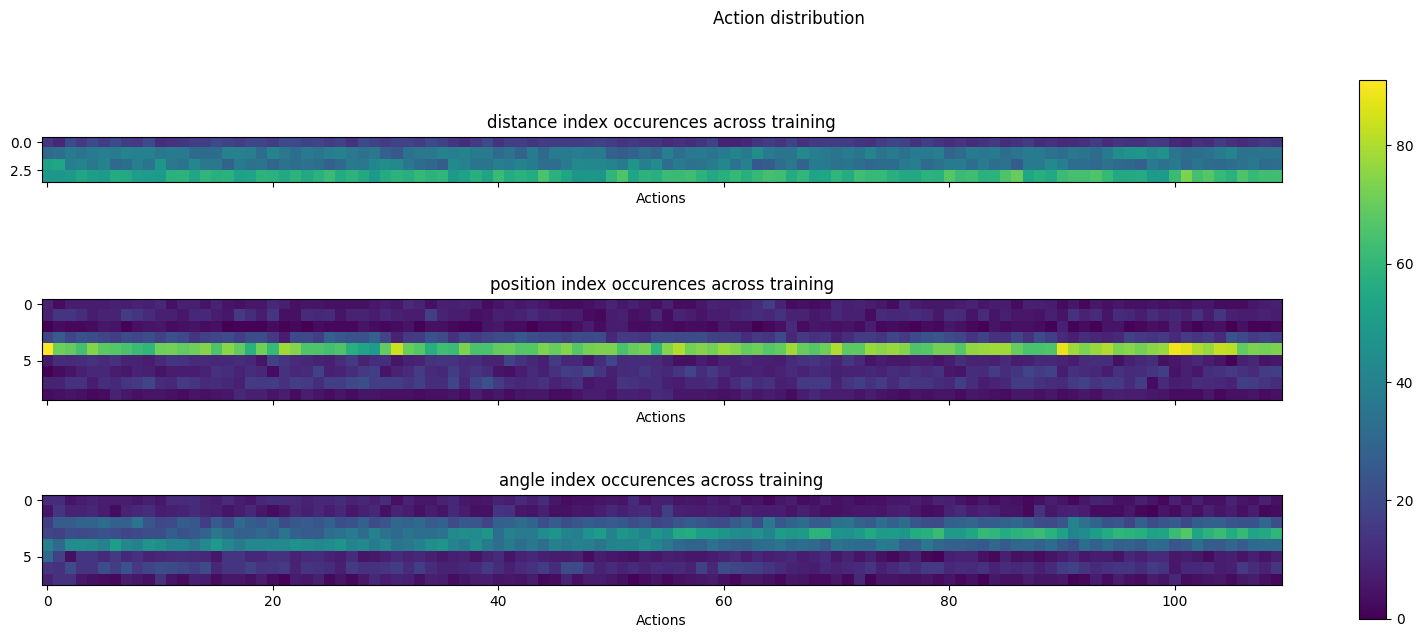

In [4]:

# If the points were too close, no angle was recorded :
# The limit was arbitrrarily chosen at 7.5 :
min_dist_norm = 7.5/(np.sqrt(2)*750)

preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : 8,
        "position_N_bins_per_dim" : 3
    },
    "observations":{
        "N_bins" : 10,
        "observation_ends_at_point" : 2
    }
}
    # We can modify these at will
from analysis_tools.preprocess import get_preprocessed_data_from_df

data = get_preprocessed_data_from_df(subjects_df,
                            preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default")



# Evolution of chosen actions for all subjects
# max_count = [jnp.max(np.sum(np.reshape(data["actions"]["vect"][action_dim]) for action_dim in ["distance","position","angle"]]

fig,axs = plt.subplots(3,1,figsize=(20,7),sharex=True)
fig.suptitle("Action distribution ")
maxcount = 0
for k,action_dim in enumerate(["distance","position","angle"]) :
    formatted_stimuli= [data["observations"]["vect"][1]]
    bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
    rewards = jnp.array(data["observations"]["deltas"])
    actions = jnp.array(data["actions"]["vect"][action_dim])

    Nsubj,Ntrials,Nactions,Ncat = actions.shape

    all_actions_stat = np.reshape(actions,(Nsubj,-1,Ncat))
    all_action_counts= np.sum(all_actions_stat,0)
    
    maxcount = max(maxcount,jnp.max(all_action_counts))

for k,action_dim in enumerate(["distance","position","angle"]) :
    formatted_stimuli= [data["observations"]["vect"][1]]
    bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
    rewards = jnp.array(data["observations"]["deltas"])
    actions = jnp.array(data["actions"]["vect"][action_dim])

    Nsubj,Ntrials,Nactions,Ncat = actions.shape

    all_actions_stat = np.reshape(actions,(Nsubj,-1,Ncat))
    all_action_counts= np.sum(all_actions_stat,0)
    
    ax = axs[k]
    img = ax.imshow(all_action_counts.T,vmin=0,vmax =maxcount,cmap="viridis")
    ax.set_title("{} index occurences across training".format(action_dim))
    ax.set_xlabel("Actions")
fig.colorbar(img, ax=list(axs))